In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from torchsummary import summary
import seaborn as sns

# LeNet - 5
Is a neural netowkr that uses convolutional neural network layers to classify handwritten datasets. The architecture consists of two convolutional layes, each followed by a subsampling layer. This is followed by three fully connected layers where the last layer provides 10 output proabilities, one for each digit 0-9. This implementation differs from vanilla LeNet-5 in the following manner:
- The input image dimension is 28x28 instead of 32x32.
- We are using linear connections in the final layer, instead of Gaussian connections. 

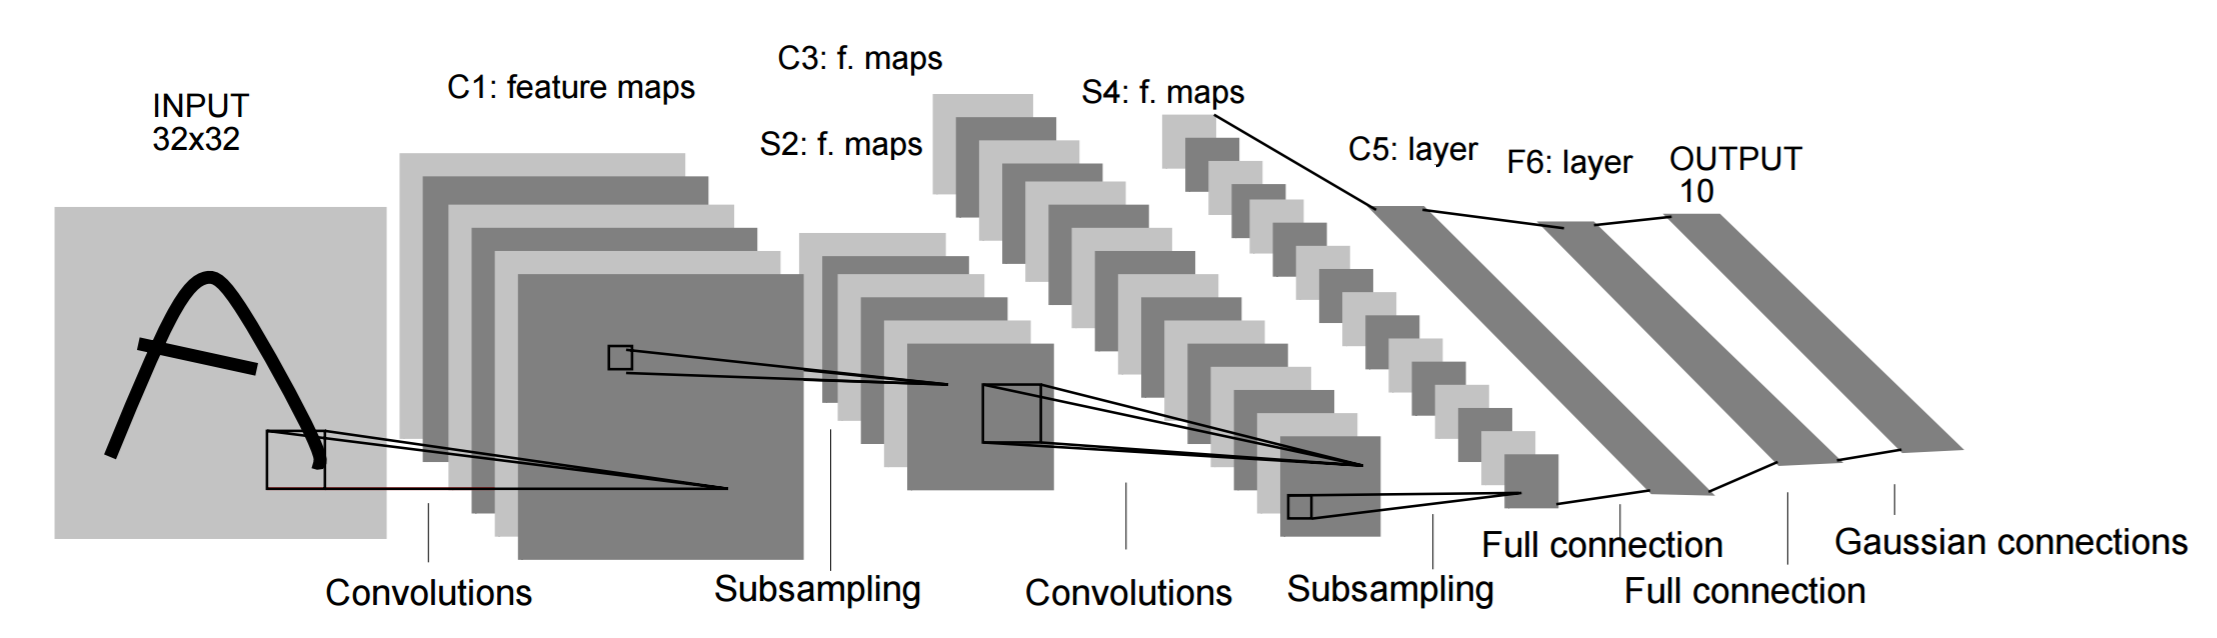

In [151]:
display.Image("imgs/lenet5.png")

In [152]:
# Repeatability of results
torch.manual_seed(1)

# We want to train our model on a hardware accelerator like the GPU, if it is available.
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

# The number of images in a mini-batch
batch_size = 64

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

Using cuda device


In [153]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

# Store separate training and validations splits in ./data
train_dataset = datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)

test_dataset = datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

# Split the train dataset and make validation dataset from this (10 %)
n_train = int(len(train_dataset) * 0.9)
n_validation = len(train_dataset) - n_train

train_dataset, validation_dataset = data.random_split(train_dataset, [n_train, n_validation])

print(f"Training samples: {len(train_dataset)}, "
      f"Validation samples: {len(validation_dataset)}, "
      f"Test samples: {len(test_dataset)}")

# Dataset loaders
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

Training samples: 54000, Validation samples: 6000, Test samples: 10000


In [154]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)
    
    def forward(self, x):
        x = self.conv1(x)                       #6x24x24
        x = F.max_pool2d(x, kernel_size=2)      #6x12x12
        x = F.relu(x)                           #6x12x12
        x = self.conv2(x)                       #16x8x8
        x = F.max_pool2d(x, kernel_size=2)      #16x4x4
        x = F.relu(x)                           #16x4x4
        x = x.view(x.shape[0], -1)              #256,-1
        x = self.fc1(x)                         #256,120
        x = F.relu(x)                           #120,120
        x = self.fc2(x)                         #120,84
        x = F.relu(x)                           #84,84
        x = self.fc3(x)                         #84,10
        return x

In [155]:
output_dim = 10
lenet = LeNet(output_dim).to(device)
summary(lenet, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                  [-1, 120]          30,840
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [156]:
optimizer = optim.Adam(lenet.parameters())
criterion = nn.CrossEntropyLoss()
lenet = lenet.to(device)
criterion = criterion.to(device)

In [157]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [158]:
def train(model, iterator, optmiser, criterion, device):
    epoch_loss, epoch_acc = 0, 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)
        optmiser.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optmiser.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [159]:
def validate(model, iterator, criterion, device):
    epoch_loss, epoch_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Validating", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [160]:
epochs = 20
best_valid_loss = float("inf")
for epoch in trange(epochs, desc="Epochs"):
    train_loss, train_acc = train(lenet, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(lenet, validation_loader, criterion, device)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(lenet.state_dict(), "models/lenet-model.pt")
    print(f"Epoch : {epoch+1} \n"
          f"Train Loss : {train_loss:.3f} | Train Accuracy : {train_acc*100:.3f} \n"
          f"Validation Loss : {val_loss:.3f} | Validation Accuracy : {val_acc*100:.3f} \n")

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 1 
Train Loss : 0.246 | Train Accuracy : 92.607 
Validation Loss : 0.084 | Validation Accuracy : 97.379 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 2 
Train Loss : 0.072 | Train Accuracy : 97.801 
Validation Loss : 0.093 | Validation Accuracy : 97.124 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 3 
Train Loss : 0.052 | Train Accuracy : 98.348 
Validation Loss : 0.053 | Validation Accuracy : 98.305 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 4 
Train Loss : 0.041 | Train Accuracy : 98.702 
Validation Loss : 0.047 | Validation Accuracy : 98.532 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 5 
Train Loss : 0.034 | Train Accuracy : 98.910 
Validation Loss : 0.042 | Validation Accuracy : 98.964 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 6 
Train Loss : 0.028 | Train Accuracy : 99.120 
Validation Loss : 0.045 | Validation Accuracy : 98.587 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 7 
Train Loss : 0.025 | Train Accuracy : 99.205 
Validation Loss : 0.038 | Validation Accuracy : 98.925 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 8 
Train Loss : 0.023 | Train Accuracy : 99.267 
Validation Loss : 0.043 | Validation Accuracy : 98.637 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 9 
Train Loss : 0.018 | Train Accuracy : 99.378 
Validation Loss : 0.035 | Validation Accuracy : 98.953 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 10 
Train Loss : 0.017 | Train Accuracy : 99.458 
Validation Loss : 0.039 | Validation Accuracy : 98.803 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 11 
Train Loss : 0.015 | Train Accuracy : 99.461 
Validation Loss : 0.033 | Validation Accuracy : 98.986 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 12 
Train Loss : 0.015 | Train Accuracy : 99.478 
Validation Loss : 0.046 | Validation Accuracy : 98.787 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 13 
Train Loss : 0.011 | Train Accuracy : 99.613 
Validation Loss : 0.030 | Validation Accuracy : 99.169 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 14 
Train Loss : 0.014 | Train Accuracy : 99.519 
Validation Loss : 0.039 | Validation Accuracy : 98.969 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 15 
Train Loss : 0.010 | Train Accuracy : 99.693 
Validation Loss : 0.037 | Validation Accuracy : 99.014 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 16 
Train Loss : 0.010 | Train Accuracy : 99.667 
Validation Loss : 0.046 | Validation Accuracy : 98.964 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 17 
Train Loss : 0.009 | Train Accuracy : 99.659 
Validation Loss : 0.046 | Validation Accuracy : 98.997 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 18 
Train Loss : 0.009 | Train Accuracy : 99.714 
Validation Loss : 0.050 | Validation Accuracy : 98.931 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 19 
Train Loss : 0.009 | Train Accuracy : 99.709 
Validation Loss : 0.051 | Validation Accuracy : 98.753 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Validating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 20 
Train Loss : 0.008 | Train Accuracy : 99.735 
Validation Loss : 0.058 | Validation Accuracy : 98.720 



In [161]:
lenet.load_state_dict(torch.load('models/lenet-model.pt'))
test_loss, test_acc = validate(lenet, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.034 | Test Acc: 99.06%


## Examining the Model
In this section, we will do two things:
- Plot the confusion matrix and see the incorrect examples where it was most confident.
- Visualise the weights of lenet

In [162]:
def make_predictions(model, iterator, device):
    model.eval()
    images, labels, probs = [], [], []
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [163]:
images, true_labels, probs = make_predictions(lenet, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [164]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

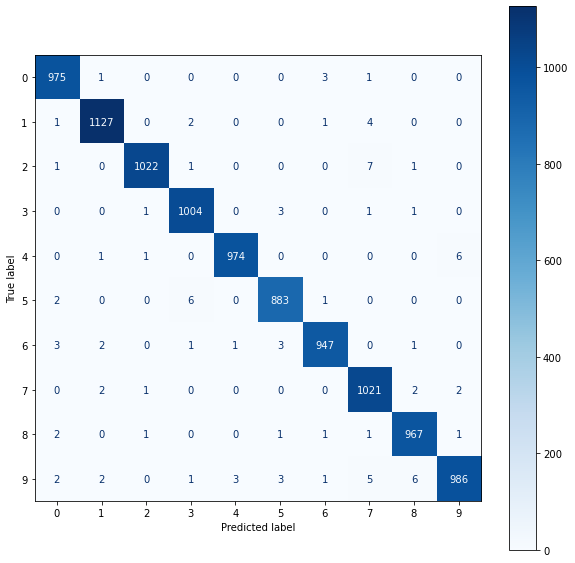

In [165]:
plot_confusion_matrix(true_labels, pred_labels)

The model has a problem in differenciating 2 and 7.

In [166]:
corrects = torch.eq(true_labels, pred_labels)
incorrect_examples = []
for image, label, prob, correct in zip(images, true_labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [167]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label}\n '
                     f'pred label: {incorrect_label}')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

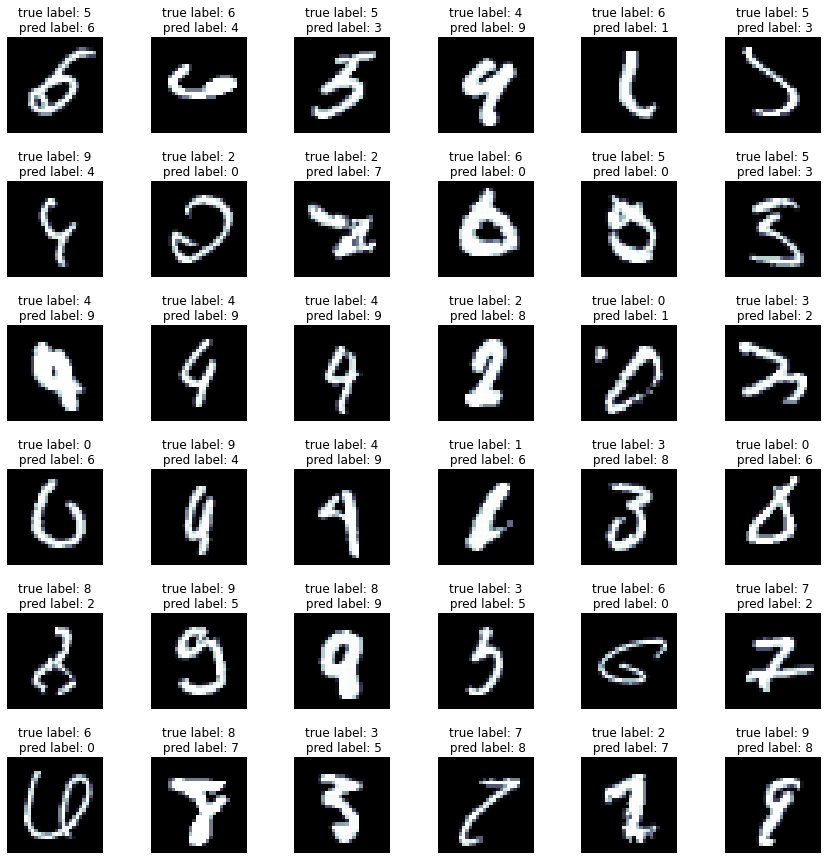

In [168]:
n_images = 36
plot_most_incorrect(incorrect_examples, n_images)

In [169]:
def plot_filters(filters):
    filters = filters.cpu()
    n_filters = filters.shape[0]
    fig = plt.figure(figsize=(20, 10))
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i][0], cmap='bone')
        ax.axis('off')

In [170]:
filters_conv1 = lenet.conv1.weight.data
filters_conv2 = lenet.conv2.weight.data
print(f"Filter Shape conv1 : {filters_conv1.shape} \n"
      f"Filter Shape conv2 : {filters_conv2.shape}")

Filter Shape conv1 : torch.Size([6, 1, 5, 5]) 
Filter Shape conv2 : torch.Size([16, 6, 5, 5])


The filters of conv1 layer:


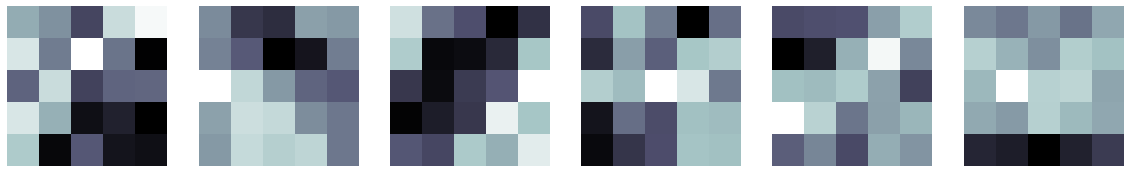

In [171]:
print(f"The filters of conv1 layer:")
plot_filters(filters_conv1)

The first of 16 filters of conv2 layer:


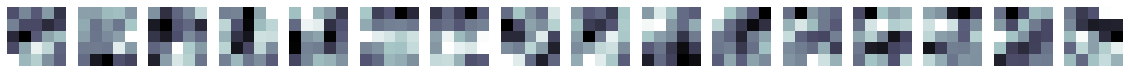

In [172]:
print(f"The first of 16 filters of conv2 layer:")
plot_filters(filters_conv2)

There are some patterns visible but it is difficult to understand what these filters have actually learned.

### References

[1] LeNet-5 : http://yann.lecun.com/exdb/lenet/

[2] PyTorch image classification : https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb

In [173]:
torch.cuda.empty_cache()